#### Import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#### Load the dataset

In [4]:
# Load dataset (Change file path if needed)
df = pd.read_csv ("Online Retail.csv")

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Data Cleaning

In [8]:
# check for duplicates
df.duplicated().sum()

5268

In [9]:
# check for missing values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df = df.dropna(subset=["Description"])

In [11]:
#Filling Missing values
df.loc[:, "CustomerID"] = df["CustomerID"].ffill()

In [12]:
df.loc[:, "CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce").fillna(0).astype(int)
df = df.drop_duplicates()

In [13]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["ReturnFlag"] = df["Quantity"].apply(lambda x: 1 if x < 0 else 0)
returns = df[df["ReturnFlag"] == 1]

C:\Users\China\AppData\Local\Temp\ipykernel_15428\1062446866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535187 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   CustomerID   535187 non-null  float64       
 7   Country      535187 non-null  object        
 8   TotalPrice   535187 non-null  float64       
 9   ReturnFlag   535187 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 44.9+ MB


#### Product Segmentation

In [16]:
#Renaming the Description to Products
df = df.rename(columns={"Description": "Product"})
df.head()

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0


In [17]:
invalid_stockcodes = ["POST", "DOT", "BANK CHARGES", "AMAZONFEE", "B","M",
                      "gift_0001_10", "gift_0001_20", "gift_0001_30", 
                      "gift_0001_40", "gift_0001_50"]

# Remove rows where StockCode is in the invalid list
df = df[~df["StockCode"].isin(invalid_stockcodes)]
df.head()

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0


In [18]:
# Aggregate Product-Level Features
product_features = df.groupby("StockCode").agg(
    TotalSold=("Quantity", "sum"),
    TotalRevenue=("TotalPrice", "sum"),
    PurchaseFrequency=("InvoiceNo", "nunique"),
    AveragePrice=("UnitPrice", "mean")
).reset_index()

In [19]:
product_features

,StockCode,TotalSold,TotalRevenue,PurchaseFrequency,AveragePrice
0,10002,860,759.890,71,1.086620
1,10080,325,119.090,23,0.393043
2,10120,192,40.320,29,0.210000
3,10123C,5,3.250,3,0.650000
4,10124A,16,6.720,5,0.420000
...,...,...,...,...,...
3942,DCGSSBOY,47,150.550,11,3.104545
3943,DCGSSGIRL,47,144.430,13,3.133077
3944,PADS,4,0.003,4,0.000750
3945,S,-58,-3039.650,19,51.060484


#### Return Rate

In [21]:
# Calculate Return Rate
returns_per_product = returns.groupby("StockCode")["Quantity"].sum().abs()
product_features["ReturnRate"] = product_features["StockCode"].map(returns_per_product).fillna(0) / product_features["TotalSold"].replace(0, 1)

returns_per_product

StockCode
10133         92
10135          1
11001        185
15034       1385
15036        744
            ... 
DCGS0073       4
DOT            1
M           4066
POST         147
S             60
Name: Quantity, Length: 2111, dtype: int64

In [22]:
# Handle Inf and NaN values
product_features.replace([float('inf'), -float('inf')], None, inplace=True)
product_features.fillna(0, inplace=True)

### TOTAL SALES

In [24]:
#Sales Feature
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

### YEAR

In [26]:
# Extract Year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year

# Group by Year and Sum Sales
yearly_trends = df.groupby('Year')['TotalSales'].sum().reset_index()
yearly_trends

,Year,TotalSales
0,2010,757934.120
1,2011,9003703.293


### QUARTER

In [28]:
# Extract Quarter from InvoiceDate

df['Quarter'] = df['InvoiceDate'].dt.quarter

#Group By Quarter and Sum of Sales
quarter_trends = df.groupby("Quarter")["TotalSales"].sum().reset_index()
quarter_trends = quarter_trends.sort_values(by = "Quarter")
quarter_trends

,Quarter,TotalSales
0,1,1757306.060
1,2,1934861.261
2,3,2387849.582
3,4,3681620.510


### MONTH

In [30]:
# Extract Month Name
df['Month'] = df['InvoiceDate'].dt.strftime('%B') #strftime(string Format Time), %B(Python Magic Code to format date to Month).

# Define the correct month order
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Ensure 'Month' is a categorical variable with the correct order
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Group by Month and Sum Sales
monthly_trends = df.groupby('Month')['TotalSales'].sum().reset_index()
monthly_trends = monthly_trends.sort_values(by = "Month")
monthly_trends

C:\Users\China\AppData\Local\Temp\ipykernel_15428\1196253533.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trends = df.groupby('Month')['TotalSales'].sum().reset_index()


,Month,TotalSales
0,January,578982.220
1,February,498585.680
2,March,679738.160
3,April,480492.311
4,May,730926.800
5,June,723442.150
6,July,677198.051
7,August,699876.090
8,September,1010775.441
9,October,1059893.470


### DAYS OF THE WEEK

In [32]:
#Extract the Days Of the Week
df['Days_of_Week'] = df['InvoiceDate'].dt.day_name()

# Define correct order of days
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert 'Days_of_Week' to categorical with correct order
df['Days_of_Week'] = pd.Categorical(df['Days_of_Week'], categories=days_order, ordered=True)

days_of_week_trends = df.groupby('Days_of_Week')['TotalSales'].sum().reset_index()
days_of_week_trends = days_of_week_trends.sort_values(by = "Days_of_Week")
days_of_week_trends

C:\Users\China\AppData\Local\Temp\ipykernel_15428\1928802460.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_of_week_trends = df.groupby('Days_of_Week')['TotalSales'].sum().reset_index()


,Days_of_Week,TotalSales
0,Monday,1616258.650
1,Tuesday,1967380.051
2,Wednesday,1737494.550
3,Thursday,2080366.580
4,Friday,1569301.491
5,Saturday,0.000
6,Sunday,790836.091


In [33]:
# Define a function to categorize periods of the day
def get_period(hour):
    if hour < 12:
        return 'Morning'
    elif hour < 17:
        return 'Afternoon'
    elif hour < 20:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to extract periods
df['Period'] = df['InvoiceDate'].dt.hour.apply(get_period)


# Define the correct order of periods
period_order = ["Morning", "Afternoon", "Evening", "Night"]

# Ensure 'Period' is a categorical variable with the correct order
df['Period'] = pd.Categorical(df['Period'], categories=period_order, ordered=True)

# Calculate total sales per period
period_trends = df.groupby('Period')['TotalSales'].sum().reset_index()
period_trends = period_trends.sort_values(by='Period')
period_trends

C:\Users\China\AppData\Local\Temp\ipykernel_15428\241994087.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_trends = df.groupby('Period')['TotalSales'].sum().reset_index()


,Period,TotalSales
0,Morning,3540352.152
1,Afternoon,5603760.171
2,Evening,601602.400
3,Night,15922.690


In [34]:
# Step 1: Compute Monetary value per Product (sum of TotalSales)
monetary_value = df.groupby("Product")["TotalSales"].sum().reset_index()

# Step 2: Merge the monetary value with the main dataframe
df = df.merge(monetary_value, on = "Product", how = "left")

# Rename the column for clarity
df.rename(columns={"TotalSales_x" : "TotalSales", "TotalSales_y" : "MonetaryValue"}, inplace = True)

#### RECENCY

In [36]:

#Setting the reference date to the end date of the analysis
reference_date = df["InvoiceDate"].max()

#Grouping data by customer and getting the latest purchase date for each customer
grouped = df.groupby("Product")["InvoiceDate"].max().reset_index()

In [37]:
#Calculating the recency for each customer by subtracting the most recent purchase date from the reference date
grouped["Recency"] = (reference_date - grouped["InvoiceDate"]).dt.days

#Merging the recency value to the dataframe
df = df.merge(grouped[["Product", "Recency"]], on = "Product", how = "left")

In [38]:
df.head(3)

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,15.30,2010,4,December,Wednesday,Morning,99612.42,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,7898.00,22
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,22.00,2010,4,December,Wednesday,Morning,7490.67,3


### FREQUENCY

In [40]:
#Calculating the frequency for each Product by counting the number of purchases
frequency = df.groupby("Product")["InvoiceNo"].count()

#Merging the frequency value to the dataframe
df = df.merge(frequency, on = "Product", how = "left")
df.rename(columns={"InvoiceNo_x" : "InvoiceNo", "InvoiceNo_y" : "Frequency"}, inplace = True)

### MONETARY VALUE

In [42]:
# Step 1: Compute Monetary value per customer (sum of TotalSales)
monetary_value = df.groupby("Product")["TotalSales"].sum().reset_index()

# Step 2: Merge the monetary value with the main dataframe
df = df.merge(monetary_value, on = "Product", how = "left")

# Rename the column for clarity
df.rename(columns={"TotalSales_x" : "TotalSales", "TotalSales_y" : "MonetaryValue"}, inplace = True)

df

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,MonetaryValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,15.30,2010,4,December,Wednesday,Morning,99612.42,0,2357,99612.42
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,7898.00,22,323,7898.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,22.00,2010,4,December,Wednesday,Morning,7490.67,3,292,7490.67
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,16090.04,0,470,16090.04
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,21769.28,0,444,21769.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532549,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0,10.20,2011,4,December,Friday,Afternoon,1214.11,0,148,1214.11
532550,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0,12.60,2011,4,December,Friday,Afternoon,4315.93,0,319,4315.93
532551,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0,16.60,2011,4,December,Friday,Afternoon,6670.71,0,301,6670.71
532552,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0,16.60,2011,4,December,Friday,Afternoon,4059.87,0,161,4059.87


In [43]:
print(df[["Recency", "Frequency", "MonetaryValue"]].dtypes)


Recency            int64
Frequency          int64
MonetaryValue    float64
MonetaryValue    float64
dtype: object


In [44]:
print(df.columns[df.columns.duplicated()])


Index(['MonetaryValue'], dtype='object')


In [45]:
df = df.loc[:, ~df.columns.duplicated()]


In [46]:
print(df.columns.tolist())  # Ensure MonetaryValue appears only once
print(df[["Recency", "Frequency", "MonetaryValue"]].dtypes)  # Check data types again


['InvoiceNo', 'StockCode', 'Product', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'ReturnFlag', 'TotalSales', 'Year', 'Quarter', 'Month', 'Days_of_Week', 'Period', 'MonetaryValue', 'Recency', 'Frequency']
Recency            int64
Frequency          int64
MonetaryValue    float64
dtype: object


In [47]:
clustering_features = df.groupby("Product").agg({
    "Recency": "min",
    "Frequency": "max",
    "MonetaryValue": "max"
}).reset_index()

print(clustering_features.head())  # Display the first few rows


                          Product  Recency  Frequency  MonetaryValue
0   4 PURPLE FLOCK DINNER CANDLES        1         39         285.70
1   50'S CHRISTMAS GIFT BAG LARGE        0        130        2341.13
2               DOLLY GIRL BEAKER        0        178        2877.50
3     I LOVE LONDON MINI BACKPACK        0         87        1624.02
4     I LOVE LONDON MINI RUCKSACK       64          1           4.15


In [48]:
df.head(3)

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,15.30,2010,4,December,Wednesday,Morning,99612.42,0,2357
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,7898.00,22,323
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,22.00,2010,4,December,Wednesday,Morning,7490.67,3,292


#### Standardardizing the Features and Finding the optimal Number of Clusters

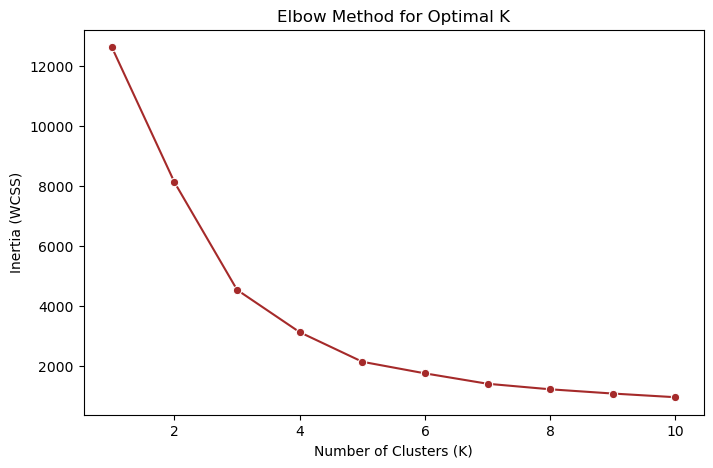

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features[["Recency", "Frequency", "MonetaryValue"]])

# Finding the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Checking for clusters from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=K_range, y=inertia, marker="o", color="brown")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [51]:
# Selecting relevant features
features = ["Recency", "Frequency", "MonetaryValue"]
clustering_features = df[features]

# Standardizing the data
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

# Applying K-Means clustering with K=3 (since optimal K was 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(clustering_features_scaled)

# Calculate mean MonetaryValue for each cluster
cluster_means = df.groupby("Cluster")["MonetaryValue"].mean()

# Assign meaningful labels based on spending behavior
cluster_mapping = {
    cluster_means.idxmin(): "Low Selling Product",
    cluster_means.idxmax(): "Best Selling Product"
}

# Assign the remaining cluster as Moderate Purchase
remaining_cluster = [c for c in cluster_means.index if c not in cluster_mapping]
if remaining_cluster:
    cluster_mapping[remaining_cluster[0]] = "Moderate Selling Product"

# Map clusters to segments
df["Segment"] = df["Cluster"].map(cluster_mapping)

# Display sample data
df.head(3)

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag,...,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Cluster,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,...,2010,4,December,Wednesday,Morning,99612.42,0,2357,0,Best Selling Product
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,...,2010,4,December,Wednesday,Morning,7898.00,22,323,2,Moderate Selling Product
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,...,2010,4,December,Wednesday,Morning,7490.67,3,292,2,Moderate Selling Product


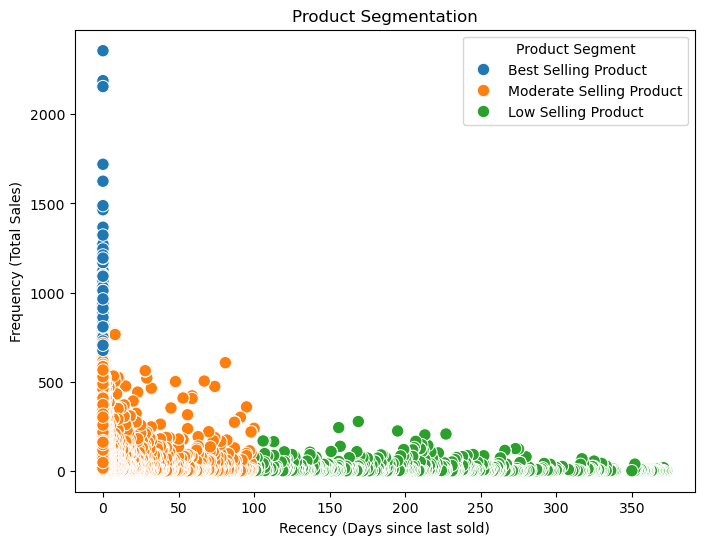

In [52]:
# 2D Scatter Plot (Recency vs Frequency)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Recency", y="Frequency", hue="Segment",s=80)
plt.title("Product Segmentation")
plt.xlabel("Recency (Days since last sold)")
plt.ylabel("Frequency (Total Sales)")
plt.legend(title="Product Segment")
plt.show()

In [53]:
df.describe(include=[float, int])

,Quantity,UnitPrice,CustomerID,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,MonetaryValue,Recency,Frequency,Cluster
count,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000,532554.000000
mean,9.706948,3.328948,15272.802221,18.329855,0.017457,18.329855,2010.921732,2.833870,9890.887690,8.840540,419.013242,1.650753
std,219.564003,6.374461,1735.684695,369.317447,0.130968,369.317447,0.268593,1.136907,16956.634015,35.479494,388.770286,0.740745
min,-80995.000000,0.000000,12346.000000,-168469.600000,0.000000,-168469.600000,2010.000000,1.000000,-7933.430000,0.000000,1.000000,0.000000
25%,1.000000,1.250000,13798.000000,3.750000,0.000000,3.750000,2011.000000,2.000000,1557.650000,0.000000,150.000000,2.000000
50%,3.000000,2.080000,15145.000000,9.870000,0.000000,9.870000,2011.000000,3.000000,4426.310000,0.000000,300.000000,2.000000
75%,10.000000,4.130000,16800.000000,17.400000,0.000000,17.400000,2011.000000,4.000000,11357.070000,1.000000,556.000000,2.000000
max,80995.000000,1867.860000,18287.000000,168469.600000,1.000000,168469.600000,2011.000000,4.000000,164459.490000,373.000000,2357.000000,2.000000


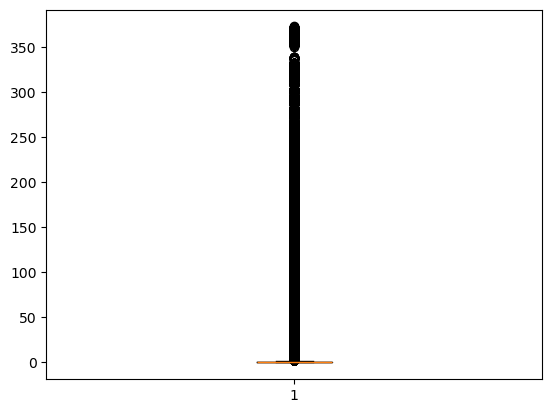

In [54]:
# plotting a boxplot to check for Outliers
plt.boxplot(clustering_features["Recency"])
plt.show()

### Predictive Modelling

In [56]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Product', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'ReturnFlag',
       'TotalSales', 'Year', 'Quarter', 'Month', 'Days_of_Week', 'Period',
       'MonetaryValue', 'Recency', 'Frequency', 'Cluster', 'Segment'],
      dtype='object')

In [57]:
df1 = df.drop(["InvoiceNo", "StockCode", "Product", "CustomerID", "Quantity", "UnitPrice"], axis = 1)
df1.head()

,InvoiceDate,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Cluster,Segment
0,2010-12-01 08:26:00,United Kingdom,15.30,0,15.30,2010,4,December,Wednesday,Morning,99612.42,0,2357,0,Best Selling Product
1,2010-12-01 08:26:00,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,7898.00,22,323,2,Moderate Selling Product
2,2010-12-01 08:26:00,United Kingdom,22.00,0,22.00,2010,4,December,Wednesday,Morning,7490.67,3,292,2,Moderate Selling Product
3,2010-12-01 08:26:00,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,16090.04,0,470,2,Moderate Selling Product
4,2010-12-01 08:26:00,United Kingdom,20.34,0,20.34,2010,4,December,Wednesday,Morning,21769.28,0,444,2,Moderate Selling Product


In [58]:
df1["Segment"].value_counts()

Segment
Moderate Selling Product    432150
Best Selling Product         85589
Low Selling Product          14815
Name: count, dtype: int64

### Handling Outliers

In [60]:
## Function to calculate lower and upper whiskers
def calculate_whiskers(col):
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return lw, uw

In [61]:
num_col = [col for col in df1.select_dtypes(include=['int64', 'float64']).columns if col != "Segment"]
num_col

['TotalPrice',
 'ReturnFlag',
 'TotalSales',
 'MonetaryValue',
 'Recency',
 'Frequency']

In [62]:
## Outlier Handling using winsorization
for i in num_col:
    lw, uw = calculate_whiskers(df1[i])
    df1[i] = np.where(df1[i] < lw, lw, df1[i])
    df1[i] = np.where(df1[i] > uw, uw, df1[i])

In [63]:
df2 = df1.copy()

In [64]:
df1.drop(["InvoiceDate"], axis = 1, inplace = True)

### Feature Encoding

In [66]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# Define the order for 'Month' and 'Days_of_Week'
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[month_order, days_order])
# Initialize LabelEncoders
label_encoder = LabelEncoder()

lbe = ["Country", "Period"]

for col in lbe:
    df1[col] = label_encoder.fit_transform(df1[col])

df1[["Month", "Days_of_Week"]] = ordinal_encoder.fit_transform(df1[["Month", "Days_of_Week"]])

In [67]:
df1.head()

,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Cluster,Segment
0,36,15.30,0.0,15.30,2010,4,11.0,2.0,2,26056.20,0.0,1165.0,0,Best Selling Product
1,36,20.34,0.0,20.34,2010,4,11.0,2.0,2,7898.00,2.5,323.0,2,Moderate Selling Product
2,36,22.00,0.0,22.00,2010,4,11.0,2.0,2,7490.67,2.5,292.0,2,Moderate Selling Product
3,36,20.34,0.0,20.34,2010,4,11.0,2.0,2,16090.04,0.0,470.0,2,Moderate Selling Product
4,36,20.34,0.0,20.34,2010,4,11.0,2.0,2,21769.28,0.0,444.0,2,Moderate Selling Product


## Handling Imbalance

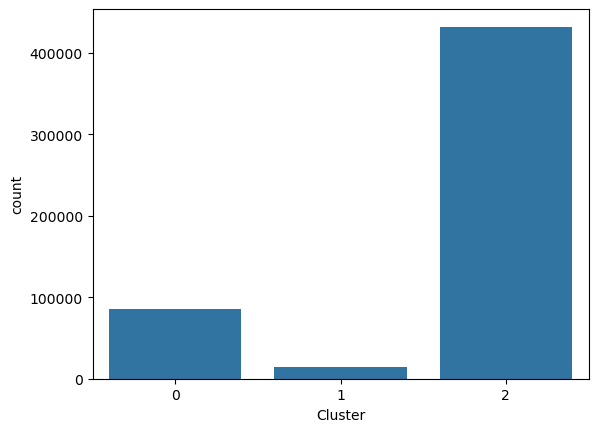

In [69]:
sns.countplot(df1, x = "Cluster")
plt.show()

In [70]:
from sklearn.utils import resample

# Separate classes
df_1 = df1[df1["Cluster"] == 0]  # Minority class
df_2 = df1[df1["Cluster"] == 1]  # Majority class
df_3 = df1[df1["Cluster"] == 2]  # Minority class

min_size = max(len(df_1), len(df_2), len(df_3))  # Get largest class size

df_1_resampled = resample(df_1, replace=True, n_samples=min_size, random_state=42)
df_2_resampled = resample(df_2, replace=True, n_samples=min_size, random_state=42)
df_3_resampled = resample(df_3, replace=True, n_samples=min_size, random_state=42)

df1 = pd.concat([df_1_resampled, df_2_resampled, df_3_resampled]).sample(frac=1, random_state=42)

df1["Cluster"].value_counts()

Cluster
1    432150
2    432150
0    432150
Name: count, dtype: int64

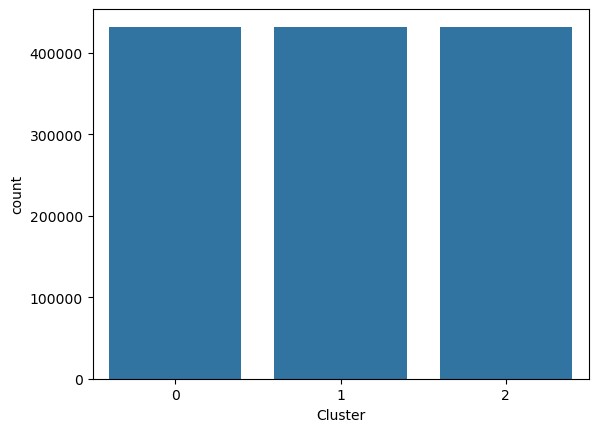

In [71]:
sns.countplot(df1, x = "Cluster")
plt.show()

In [72]:
df.head(3)

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ReturnFlag,...,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Cluster,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,...,2010,4,December,Wednesday,Morning,99612.42,0,2357,0,Best Selling Product
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,...,2010,4,December,Wednesday,Morning,7898.00,22,323,2,Moderate Selling Product
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,...,2010,4,December,Wednesday,Morning,7490.67,3,292,2,Moderate Selling Product


## FEATURE SCALING

In [74]:
df1.head(3)

,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Cluster,Segment
77520,36,7.50,0.0,7.50,2011,1,1.0,1.0,0,5426.27,2.5,125.0,1,Low Selling Product
152043,36,14.75,0.0,14.75,2011,2,3.0,2.0,0,4940.03,0.0,453.0,2,Moderate Selling Product
112088,36,2.34,0.0,2.34,2011,1,2.0,1.0,0,85.61,2.5,28.0,1,Low Selling Product


In [75]:
X = df1.drop(columns=["Segment", "Cluster"])
y = df1["Cluster"]

In [76]:
#Checking if they are of the same rows and columns

print(X.shape)
print(y.shape)

(1296450, 12)
(1296450,)


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

## Model Selection

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, confusion_matrix

In [81]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, objective="multi:softmax", num_class=3, random_state=42)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [82]:
#Train the Model
model.fit(sc_X_train, y_train)
  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [83]:
#Make Prediction
y_pred = model.predict(sc_X_test)

In [84]:
cluster_mapping = {
    0: "Low Selling Product",
    1: "Moderate Selling Product",
    2: "Best Selling Product"
}

y_pred_labels = [cluster_mapping[label] for label in y_pred]

In [85]:
result_df = X_test.copy()  # Copy the test features

result_df["Predicted Cluster"] = y_pred
result_df["Predicted Segment"] = y_pred_labels

result_df.head()

,Country,TotalPrice,ReturnFlag,TotalSales,Year,Quarter,Month,Days_of_Week,Period,MonetaryValue,Recency,Frequency,Predicted Cluster,Predicted Segment
258915,36,37.875,0.0,37.875,2011,3,6.0,3.0,0,26056.20,0.0,1165.0,0,Low Selling Product
236636,36,2.460,0.0,2.460,2011,2,5.0,0.0,2,1120.29,1.0,163.0,2,Best Selling Product
153961,36,4.160,0.0,4.160,2011,2,3.0,3.0,0,22791.99,0.0,884.0,0,Low Selling Product
169001,36,1.260,0.0,1.260,2011,2,4.0,6.0,2,674.11,2.5,108.0,1,Moderate Selling Product
216586,36,16.500,0.0,16.500,2011,2,5.0,3.0,0,18482.03,0.0,1121.0,0,Low Selling Product


In [86]:
## Evaluation
f1 = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")


# print(f"XGboost Model Performance: {name}")
print(f"F1_Score: {f1:.2f}")
print(f"Recall_Score: {recall:.2f}")

F1_Score: 0.98
Recall_Score: 0.98


## FEATURE IMPORTANCE

In [88]:
# Get feature importance
importance = model.feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df

,Feature,Importance
10,Recency,0.782087
11,Frequency,0.118481
4,Year,0.047851
9,MonetaryValue,0.018233
6,Month,0.015926
5,Quarter,0.014684
1,TotalPrice,0.001780
0,Country,0.000885
8,Period,0.000049
7,Days_of_Week,0.000025


C:\Users\China\AppData\Local\Temp\ipykernel_15428\1394878711.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")


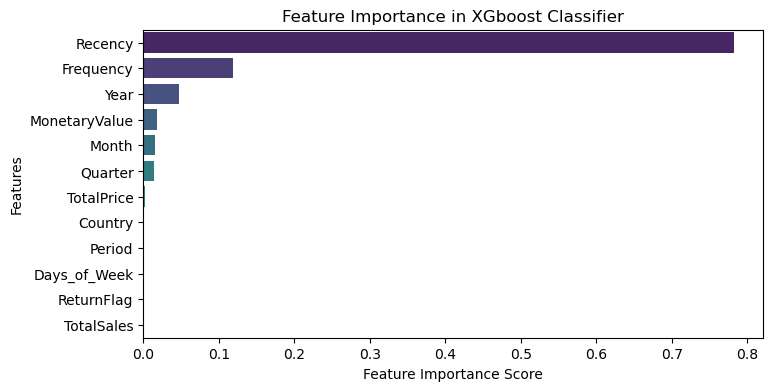

In [89]:
# Plot feature importance using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGboost Classifier")
plt.show()

## TIME SERIES ANALYSIS

In [91]:
!pip install prophet

In [92]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Prepare Data
df = df[["InvoiceDate", "TotalSales"]]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date  # Extract only the date part
df = df.groupby("InvoiceDate").agg({"TotalSales": "sum"}).reset_index()
df.columns = ["ds", "y"]  # Prophet requires 'ds' (date) and 'y' (values)
df = df.sort_values("ds").reset_index(drop=True)  # Ensure proper indexing

In [93]:
df

,ds,y
0,2010-12-01,57167.10
1,2010-12-02,46055.32
2,2010-12-03,43465.65
3,2010-12-05,30517.67
4,2010-12-06,50801.25
...,...,...
300,2011-12-05,78493.55
301,2011-12-06,52812.37
302,2011-12-07,72571.10
303,2011-12-08,76485.64


## SPLITTING DATA INTO TRAIN AND TEST SET

In [95]:
# Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size].reset_index(drop=True), df.iloc[train_size:].reset_index(drop=True)

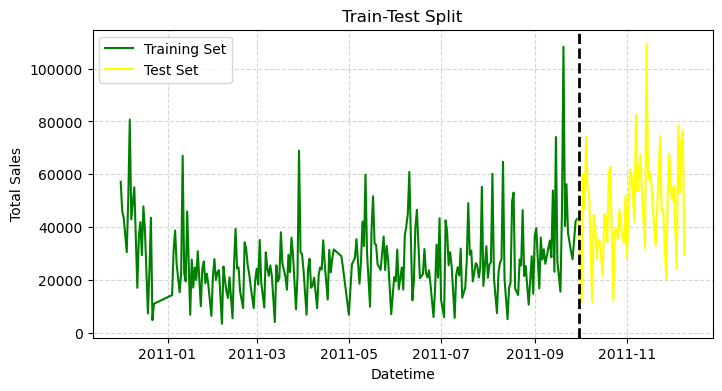

In [96]:
# Train-Test Split Visualization
plt.figure(figsize=(8, 4))
plt.plot(train["ds"], train["y"], label="Training Set", color="green")
plt.plot(test["ds"], test["y"], label="Test Set", color="yellow")
plt.axvline(df["ds"].iloc[train_size], color="black", linestyle="--", linewidth=2)  # Split line
plt.xlabel("Datetime")
plt.ylabel("Total Sales")
plt.title("Train-Test Split")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## FUTURE DATES AND FORCAST

In [98]:
# Initialize Prophet Model
model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False, 
                seasonality_mode="additive")  # Improved seasonality handling
model.fit(train)

11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
# Generate Future Dates & Predict
future = model.make_future_dataframe(periods=len(test), freq="D")
forecast = model.predict(future)

## PLOTTING THE FORCAST

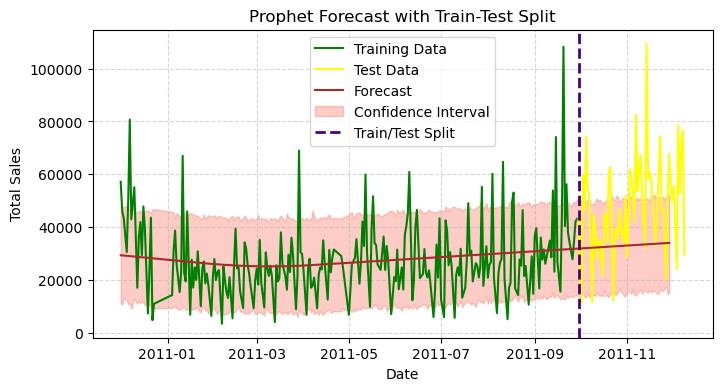

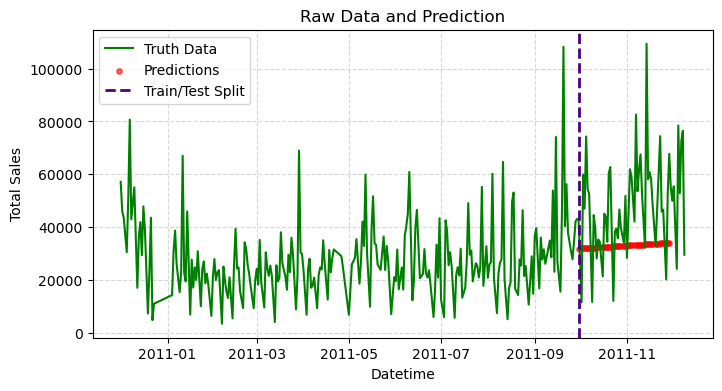

In [101]:
# Create Forecast Plot with Custom Colors
fig, ax = plt.subplots(figsize=(8, 4))

# Plot actual (historical) values
ax.plot(train["ds"], train["y"], label="Training Data", color="green")
ax.plot(test["ds"], test["y"], label="Test Data", color="yellow")

# Prophet Forecast Line
ax.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="brown")

# Uncertainty Interval (Shaded Area)
ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], 
                color="salmon", alpha=0.4, label="Confidence Interval")

# Formatting
plt.axvline(df["ds"].iloc[train_size], color="indigo", linestyle="--", linewidth=2, label="Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Prophet Forecast with Train-Test Split")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Extract predictions that match test set dates
test_forecast = forecast.set_index("ds")["yhat"].reindex(test["ds"]).values  # More robust indexing

# Create Figure
plt.figure(figsize=(8, 4))

# Plot Truth Data (Actual Sales in Blue)
plt.plot(df["ds"], df["y"], label="Truth Data", color="green")

# Plot Predictions (Test Period in Red)
plt.scatter(test["ds"], test_forecast, label="Predictions", color="red", s=15, alpha=0.6)

# Formatting
plt.axvline(df["ds"].iloc[train_size], color="indigo", linestyle="--", linewidth=2, label="Train/Test Split")
plt.xlabel("Datetime")
plt.ylabel("Total Sales")
plt.title("Raw Data and Prediction")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## EVALUATE THE MODEL

In [103]:
test_forecast = forecast.set_index("ds")["yhat"].reindex(test["ds"]).fillna(method="ffill").values

C:\Users\China\AppData\Local\Temp\ipykernel_15428\3046403931.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_forecast = forecast.set_index("ds")["yhat"].reindex(test["ds"]).fillna(method="ffill").values


In [104]:

# Compute Mean Absolute Error
mae = mean_absolute_error(test["y"].values, test_forecast)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 19170.79
